# Korean, Question-pair classification

데이터의 질문들을 두 개씩 비교해서 같은 질문인지 아닌지 맞추기 위해 미리 데이터 약 2만개에 핸드 레이블링함 

소스 출처 : https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots

#  개관



질문쌍에 대한 TF-IDF 인코딩  

기본 피처 엔지니어링과 저차원 공간에서의 임베딩  

병렬 좌표 시각화

모델 선택 및 평가 + 샘플 제출.

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

print(check_output(["ls", "./data"]).decode("utf8"))


kor_Pair_test.csv
kor_pair_train.csv



In [17]:

df = pd.read_csv("./data/kor_pair_train.csv").fillna("")
df.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6888 entries, 0 to 6887
Data columns (total 6 columns):
id              6888 non-null int64
qid1            6888 non-null int64
qid2            6888 non-null int64
question1       6888 non-null object
question2       6888 non-null object
is_duplicate    6888 non-null int64
dtypes: int64(4), object(2)
memory usage: 323.0+ KB


In [19]:
df.shape

(6888, 6)

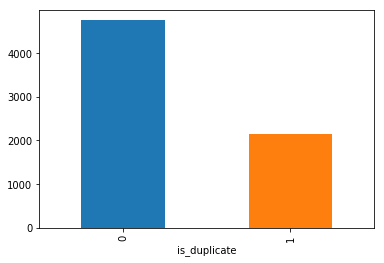

In [20]:
df.groupby("is_duplicate")['id'].count().plot.bar()

# Feature construction

1.  각 질문에 대해 표준 TF-IDF 인코딩

2. 계산상의 복잡성과 스토리지 요구 사항을 제한하기 위해 TF-IDF를 사용하여  고빈도 용어를 인코딩하고 나서 데이터의 하위 샘플을 살펴볼 것이다.

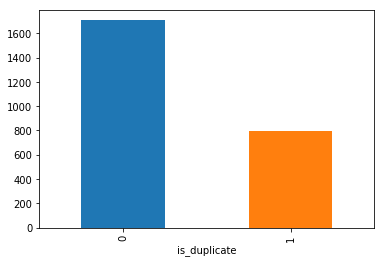

In [21]:
dfs = df[0:2500]
dfs.groupby("is_duplicate")['id'].count().plot.bar()

상위 50 %의 행에 질문 1 만 있고 하위 50 %에 질문 2만 있는 데이터 프레임으로 만든다.               
원래 데이터 프레임과 동일한 순서로 정렬

In [22]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




(5000, 3)

## Transform questions by TF-IDF.

사이킷런의 HashingVectorizer에 대한 공식 문서:   

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html


### HashingVectorizer 장점:


메모리에 어휘 사전을 저장할 필요가 없으므로 매우 적은 메모리를 쓰면서 대규모 데이터 세트를 다룰 수 있다.  


constructor parameter 외에 다른 상태를 보유하지 않기 때문에 pickle 및 un-pickle이 빠르다.  


fit되는 동안에 계산하는 상태가 없기 때문에 streaming(부분 적합) 또는 병렬 파이프 라인에서 사용할 수 있다.


### HashingVectorizer 단점 (in-memory에서  단어의 CountVectorizer를 사용하는 것과 대비해서) 

모델에 어떤 기능이 가장 중요한가를 살펴 볼 때 문제가 될 수 있는 것으로 inverse transform (피쳐 인덱스에서 문자열 피쳐 이름으로)을 계산할 방법이 없다.


충돌하는 경우가 있다 : 서로 다른 토큰을 동일한 기능 인덱스에 매핑 할 수 있다. 그러나 n_features가 충분히 큰 경우인 (예 : 텍스트 분류 문제의 경우 2 ** 18)에는 실제로 문제가 되지 않는다.  


IDF 가중치가 없기 때문에 transformer가 자기 상태를 유지하게 된다.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<5000x256 sparse matrix of type '<class 'numpy.float64'>'
	with 5843 stored elements in Compressed Sparse Row format>

In [24]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 5001 stored elements in Compressed Sparse Row format>

# 3D t-SNE embedding

t-SNE를 사용하여 TF-IDF 벡터를 3 차원 대화형 분산 플롯으로 만드는 과정

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.033s...
[t-SNE] Computed neighbors for 2500 samples in 2.925s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.145s
[t-SNE] Iteration 50: error = 79.6916962, gradient norm = 0.1373696 (50 iterations in 7.644s)
[t-SNE] Iteration 100: error = 81.7439575, gradient norm = 0.1408478 (50 iterations in 8.579s)
[t-SNE] Iteration 150: error = 84.6126099, gradient norm = 0.1288410 (50 iterations in 8.322s)
[t-SNE] Iteration 200: error = 85.9673233, gradient norm = 0.1028171 (50 iterations in 7.359s)
[t-SNE] Iteration 250: error = 88.1472931, gradient norm = 0.0866359 (50 iterations in 7.058s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.147293
[t-SNE] Iteration 300: erro

In [26]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = dfs['is_duplicate'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Feature EDA

character length of questions 1 and 2  

number of words in question 1 and 2  

normalized word share count.  

In [32]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df['word_share'] = df.apply(normalized_word_share, axis=1)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1,17,8,4,2,0.0
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1,20,20,5,5,0.0
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1,11,13,2,3,0.0
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1,22,6,6,1,0.0
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1,13,16,3,5,0.0


정규화된 어휘들(normalized word)이 오른쪽에 겹쳐 있는데,  유사성이 없는 질문의 경우는 거의 중복이 없다고  해석할 수 있다.

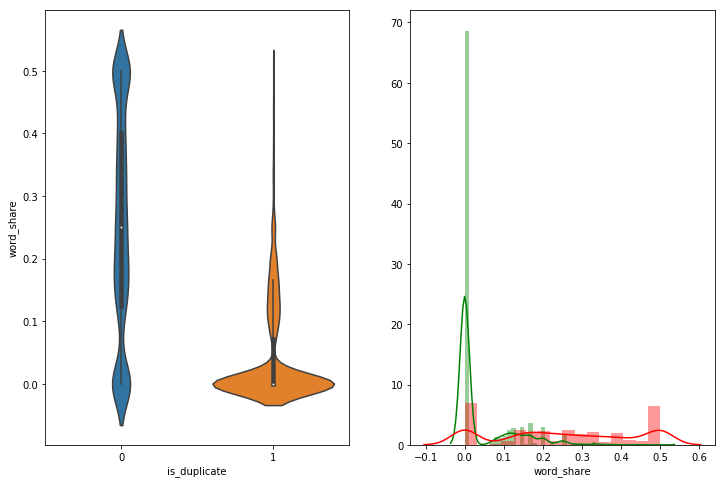

In [33]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:50000])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

스캐터 플랏에서 색상이 중복되는 부분의 질문쌍의 문자 길이는 우리가 이전에 계산한 word share coefficient의 크기를 보여준다.

In [34]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

In [35]:
layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

# Model starter

지금까지 구축 한 기본 기능으로 모델을 러닝할 것이다.

이를 위해 Logisitic 회귀 분석법을 사용할 것이다. 

CV, ROI 및 PR 곡선을 홀드 아웃 세트에 신속하게 입력하고 제출해 보자.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

X = scaler.transform(df[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4614, 5), (2274, 5), (4614,), (2274,))

Run cross-validation with a few hyper parameters.

In [37]:
clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1e-06, 0.001, 1.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

validation 결과를 인쇄:  


어떤 정규식을 썼는가에 관계 없이 강하게 정규화된 모델이 다른 두 모델보다 훨씬 나쁜 negative log loss를 보이고 있다.


In [38]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

5. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 1e-06, 'penalty': 'l1'}
4. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 1e-06, 'penalty': 'l2'}
5. Mean validation neg log loss: -0.693 (std: 0.000) - {'C': 0.001, 'penalty': 'l1'}
3. Mean validation neg log loss: -0.606 (std: 0.000) - {'C': 0.001, 'penalty': 'l2'}
1. Mean validation neg log loss: -0.406 (std: 0.003) - {'C': 1.0, 'penalty': 'l1'}
2. Mean validation neg log loss: -0.409 (std: 0.003) - {'C': 1.0, 'penalty': 'l2'}


In [39]:
print(cv.best_params_)
print(cv.best_estimator_.coef_)

{'C': 1.0, 'penalty': 'l1'}
[[ 4.4619514   6.29164892 -2.39671629 -1.91686415 -6.12213778]]


# ROC

ROC 커브는 위키 피디아의 설명과 그림 참고

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

<img src="ROC_curves.svg" width="500"><BR>

Guora에 올라온 설명과 그림이 가장 이해가 쉽게 설명된 듯하다.

True Positive = Correctly identified  

True Negative = Correctly rejected  

True Negative = Correctly rejected  

False Positive = Incorrectly identified) 

https://www.quora.com/What-is-the-best-example-for-false-negative-false-positive-true-negative-and-true-positive-in-machine-learning

<img src="tpfp.png" width="500"><BR>

C: 1e-06, parameters [[-0.00024085 -0.00018542 -0.00024049 -0.00017343 -0.00073101]] and intercept [-0.00087645]
C: 0.0001, parameters [[-0.0202366  -0.01542421 -0.0204641  -0.01463021 -0.06712809]] and intercept [-0.07443952]
C: 1.0, parameters [[ 3.4172769   4.32793332 -1.49600946 -0.40582934 -5.87108921]] and intercept [-0.79923863]


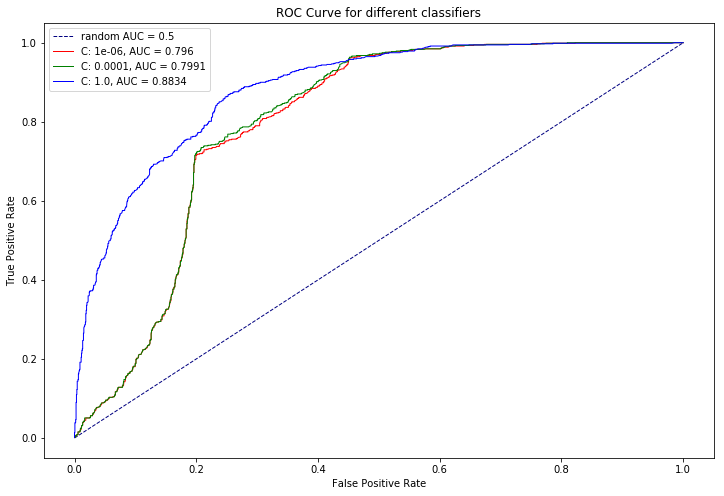

In [40]:
colors = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'brown', 'r']
lw = 1
Cs = [1e-6, 1e-4, 1e0]

plt.figure(figsize=(12,8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

labels = []
for idx, C in enumerate(Cs):
    clf = LogisticRegression(C = C)
    clf.fit(X_train, y_train)
    print("C: {}, parameters {} and intercept {}".format(C, clf.coef_, clf.intercept_))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=colors[idx])
    labels.append("C: {}, AUC = {}".format(C, np.round(roc_auc, 4)))

plt.legend(['random AUC = 0.5'] + labels)

# Precision-Recall Curve

negatives와 positives 샘플이 꽤 잘 분리되고 있음을 알 수 있다.

Text(0,0.5,'Precision')

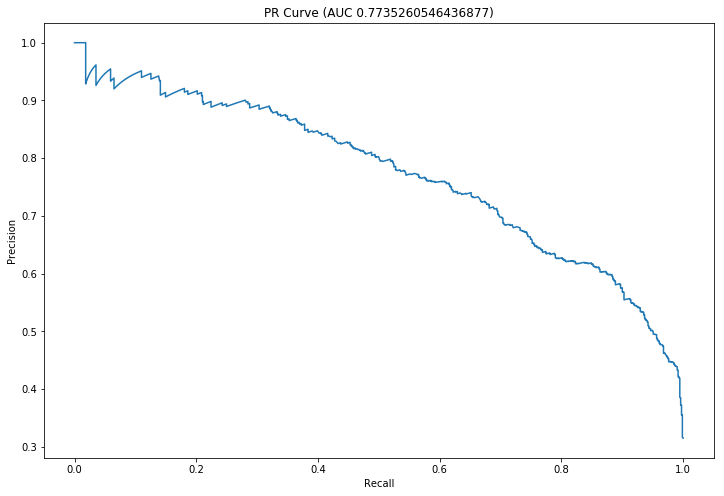

In [41]:
pr, re, _ = precision_recall_curve(y_test, cv.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')

# Prepare submission

테스트 데이터를 읽어 들인 후 트레이닝 데이터에 사용한 것과 동일한 변환 적용               
features를 다시 스케일링

In [49]:
dftest = pd.read_csv("./data/kor_pair_test.csv").fillna("")

dftest['q1len'] = dftest['question1'].str.len()
dftest['q2len'] = dftest['question2'].str.len()

dftest['q1_n_words'] = dftest['question1'].apply(lambda row: len(row.split(" ")))
dftest['q2_n_words'] = dftest['question2'].apply(lambda row: len(row.split(" ")))

dftest['word_share'] = dftest.apply(normalized_word_share, axis=1)

dftest.head()

,test_id,question1,question2,is_duplicate,Unnamed: 4,q1len,q2len,q1_n_words,q2_n_words,word_share
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,,11,18,3,4,0.000
1,2,2년 가량의 연애,2년 만났어,0,,9,6,3,2,0.200
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,,11,15,3,5,0.125
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,,14,17,3,4,0.000
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,,19,21,3,5,0.000


전체 훈련 세트에서 최상의 하이퍼 파라미터를 찾아서 cross-validation에서 발견된 최선의 추정량으로 재훈련


In [50]:
retrained = cv.best_estimator_.fit(X, y)

X_submission = scaler.transform(dftest[['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_share']])

y_submission = retrained.predict_proba(X_submission)[:,1]

submission = pd.DataFrame({'test_id': dftest['test_id'], 'is_duplicate': y_submission})
submission.head()

,test_id,is_duplicate
0,1,0.765155
1,2,0.066918
2,3,0.272884
3,4,0.798263
4,5,0.902163


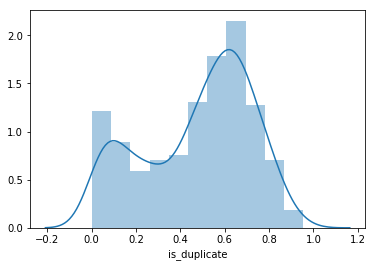

In [51]:
sns.distplot(submission.is_duplicate[0:2000])

In [52]:
submission.to_csv("submission.csv", index=False)